In [2]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

Kearns and Valiant (1988/89): Can many weak learners be combined to create a strong learner?

The answer turns out to be yes.  The general method is called **Boosting**.  We'll look at an algorithm that uses these ideas, coined as NIBLS (Non-parametric, Iterated, Boosted Linear Splines) by James Kinney '18.

Let's think about piecewise linear splines, especially with relatively few knots.  They are also not strong learners (they typically won't give you a particularly small sum of squared residuals).  But because of that, when they fit something, they are likely to be fitting signal (assuming a strong signal to noise ratio that we really need). Strong learners have the ability to fit not just signal, but noise also.  In a sense, this is our challenge.  How do we rein in a strong learner so that it is able to fit a fairly general class of signal, but not noise.  Cross-validation has been our main weapon in this fight thus far. 

Cross-validation works fine for low dimensional tuning parameter situations (a single bandwidth $h$ for example).  It will be a computational challenge if there are many tuning parameters.  A single bandwidth $h$ suggests that you think the smoothness over the support of the data is constant.  If not, you should be fitting a different value of $h$ everywhere.  Now we have to cross-validate a function $h(x)$.  From 1 dimension to infinite dimensions.  Great. So maybe we should try to avoid choosing (consequential) parameters all together.  Let's try.

Here's data: 

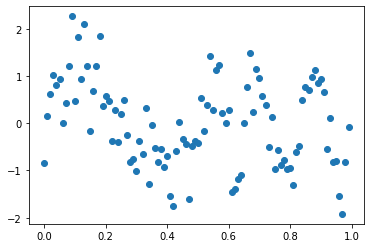

In [36]:
x = np.arange(0, 4*np.pi, 4*np.pi/100)
rnorm = np.random.normal(loc=0,scale=np.sqrt(0.3),size=100)
y = np.sin(x)*(x<(2*np.pi))+np.sin(3*x)*(x>(2*np.pi))+rnorm
x = x/(4*np.pi)
fig, ax = plt.subplots()
ax.scatter(x, y)

Notice that the required smoothness early is much higher than later.  It would be beneficial to have a large $h$ early on, and a small $h$ for the second half of the data.  We haven't done anything like that.  

(We might also check out the xkcd data set as we know it well at this point.)  

To put it on [0,1], transform $x$ as

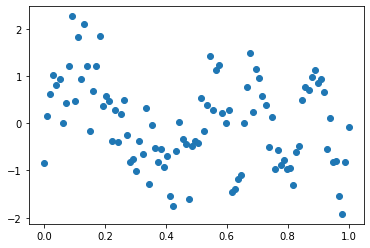

In [37]:
x = (x - np.min(x))/(np.max(x)-np.min(x))
fig, ax = plt.subplots()
ax.scatter(x, y)

As suggest by the name, we are going to use *linear splines*: $x'=(x-k){\bf 1}(x>k)$, so 0 until *knot* $k$ and then linear with slope 1 after $k$.  

So our fit is going to be linear combinations of these sort of basis functions

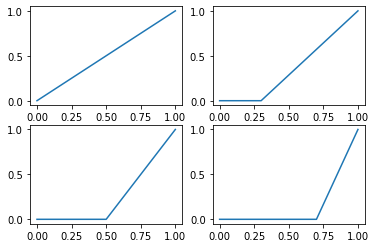

In [34]:
x1, y1 = [0, 1], [0, 1]
x2, y2 = [0, 0.3, 1], [0, 0, 1]
x3, y3 = [0, 0.5, 1], [0, 0, 1]
x4, y4 = [0, 0.7, 1], [0, 0, 1]

# Create four polar axes and access them through the returned array
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x1, y1)
axs[0, 1].plot(x2, y2)
axs[1, 0].plot(x3, y3)
axs[1, 1].plot(x4, y4)

for knots chosen at .3, .5, and .7 in addition to the linear term.  You can see the kind of estimates we might be able to get back from these linear combinations:

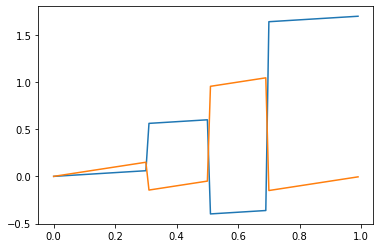

In [39]:
a  = np.arange(0, 1, .01)
fig, ax = plt.subplots()
ax.plot(a, .2*a + .5*(a > 0.3) - (a > 0.5) + 2 *  (a > 0.7))
ax.plot(a, .5*a - .3*(a > .3) + (a > .5) - 1.2 *  (a > 0.7))



Let's let $k=4$.  Since we don't know where they should be, let's choose these randomly.  To keep it from fitting noise, let's force the knots to not be right next to each other (or the boundary).  (Let's assume that $x$ is in the unit interval, as it is for the above data).  Write code that randomly picks four numbers in (0,1) such that they aren't within $m$ of each other. Let $m=.04$. (Check out the *dist* function.  Not quite what you want, but *max(dist(runif(4)))}* finds the furthest apart a pair of points are out of 4 random uniforms.) 

In [54]:
def pick_knots(k,m):
    knots = np.arange(0,1, m)
    return np.random.choice(knots, k)
pick_knots(4, 0.04)

array([0.28, 0.04, 0.32, 0.4 ])

Create the basis functions based on your chosen knots $k_i$ and run linear regression using *lm*. It's piecewise linear, and we think our target is smoother, so let's smooth this (but ever so slightly).  We are going to iterate this, what happens if I slightly smooth something repeatedly?  (Think about what happens if I repeatedly run sandpaper over a piece of wood.) We can just run our regression smoother (reg.norm or whatever) over the fitted values if our data is on a grid (like it is with our data above)!

```{r}
basis.fns <- function(knots, x) {
  x <- cbind(x, (x-knots[1])*(x>knots[1]))
  return(x)
}

#fit <- lm(y~x) #where y is a vector and x can be a matrix of predictors, columns are variables
#add fit$fitted.values - a fit in the residual space, back to the fit in the data space
```

Take the residuals ($e_i=y_i-\hat{y}_i$), and see if we can learn any remaining signal from them.  Fit the same estimator to the residuals.  Add this fit back to the fit in the data space, and smooth again (ever so slightly).

Repeat many times (500?).  Each time keeping track of the fit and the residual sum of squares $Q(B)$.

Pick the estimator that has the lowest sum of squares (a terrible idea if we thought that this might eventually fit noise).

How does this idea compare to regularization (penalized) methods that we have been exploring?

How does the smoothness of the estimator behave over the range of the data?

What happens when successive smooths oversmooth a region of the data?